In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from game_env import Game2048Env
from horizon_dqn import HorizonAgent

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.3.1+cu121
CUDA available: True


## Load Trained Horizon DQN Model

In [2]:
# Create environment
env = Game2048Env()

# Create Horizon DQN agent
agent = HorizonAgent(
    state_shape=(4, 4),
    num_actions=4,
    lr=1e-4,
    gamma=0.99,
    buffer_size=100000,
    batch_size=64,
    target_update_freq=1000,
    n_step=3,
    num_atoms=32
)

# Load the trained model
model_path = "horizon_dqn_final_model.pt"  # Change this to load different checkpoints
agent.load(model_path)

print(f"Loaded trained model from: {model_path}")
print(f"Agent device: {agent.device}")
print(f"Learn steps: {agent.learn_step}")
print(f"\nHorizon DQN Architecture:")
print(agent.online_net)

Loaded trained model from: horizon_dqn_final_model.pt
Agent device: cuda
Learn steps: 1920318

Horizon DQN Architecture:
HorizonDQN(
  (conv1): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (v_fc): NoisyLinear()
  (v_head): NoisyLinear()
  (a_fc): NoisyLinear()
  (a_head): NoisyLinear()
)


## Evaluate Agent Performance

In [3]:
def evaluate_agent(agent, env, num_episodes=100):
    """
    Evaluate the trained Horizon DQN agent.
    """
    eval_scores = []
    eval_max_tiles = []
    eval_moves = []
    
    # Set to eval mode (Noisy Nets will use mean weights)
    agent.online_net.eval()
    
    for episode in tqdm(range(num_episodes), desc="Evaluating"):
        state, _ = env.reset()
        done = False
        
        while not done:
            # Greedy action selection (training=False uses mean weights)
            action = agent.select_action(state, training=False)
            state, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        eval_scores.append(info['score'])
        eval_max_tiles.append(info['max_tile'])
        eval_moves.append(info['moves'])
    
    # Back to train mode
    agent.online_net.train()
    
    # Print statistics
    print(f"\n{'='*60}")
    print(f"Horizon DQN Evaluation Results ({num_episodes} episodes):")
    print(f"{'='*60}")
    print(f"  Average Score: {np.mean(eval_scores):.2f} ± {np.std(eval_scores):.2f}")
    print(f"  Average Max Tile: {np.mean(eval_max_tiles):.2f} ± {np.std(eval_max_tiles):.2f}")
    print(f"  Average Moves: {np.mean(eval_moves):.2f} ± {np.std(eval_moves):.2f}")
    print(f"  Max Score: {np.max(eval_scores)}")
    print(f"  Max Tile Achieved: {np.max(eval_max_tiles)}")
    print(f"  Min Score: {np.min(eval_scores)}")
    print(f"  Min Tile: {np.min(eval_max_tiles)}")
    
    # Count tile distribution
    tile_dist = Counter(eval_max_tiles)
    print(f"\n  Max Tile Distribution:")
    print(f"  {'-'*40}")
    for tile in sorted(tile_dist.keys(), reverse=True):
        count = tile_dist[tile]
        pct = 100 * count / num_episodes
        bar = '█' * int(pct / 2)
        print(f"    {tile:>5}: {count:>3} ({pct:>5.1f}%) {bar}")
    print(f"{'='*60}")
    
    return eval_scores, eval_max_tiles, eval_moves

# Run evaluation
eval_scores, eval_max_tiles, eval_moves = evaluate_agent(agent, env, num_episodes=100)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Horizon DQN Evaluation Results (100 episodes):
  Average Score: 1906.96 ± 1869.82
  Average Max Tile: 185.80 ± 159.01
  Average Moves: 166.57 ± 116.53
  Max Score: 9656
  Max Tile Achieved: 1024
  Min Score: 4
  Min Tile: 4

  Max Tile Distribution:
  ----------------------------------------
     1024:   1 (  1.0%) 
      512:  10 ( 10.0%) █████
      256:  25 ( 25.0%) ████████████
      128:  36 ( 36.0%) ██████████████████
       64:  18 ( 18.0%) █████████
       32:   8 (  8.0%) ████
       16:   1 (  1.0%) 
        4:   1 (  1.0%) 


## Visualize Evaluation Results

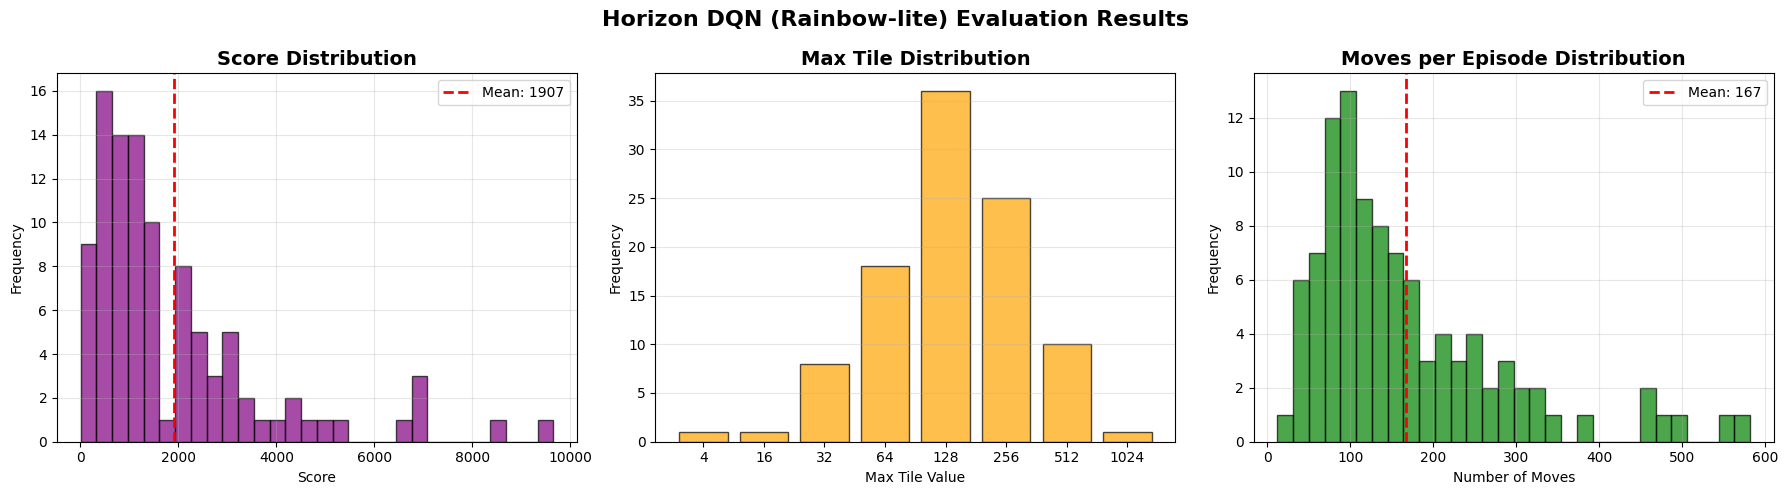

Evaluation visualization saved as 'horizon_evaluation_results.png'


In [4]:
# Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score distribution
axes[0].hist(eval_scores, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0].axvline(np.mean(eval_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(eval_scores):.0f}')
axes[0].set_title('Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Max tile distribution
tile_counts = Counter(eval_max_tiles)
tiles = sorted(tile_counts.keys())
counts = [tile_counts[t] for t in tiles]
axes[1].bar(range(len(tiles)), counts, tick_label=tiles, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Max Tile Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Max Tile Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3, axis='y')

# Moves distribution
axes[2].hist(eval_moves, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(np.mean(eval_moves), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(eval_moves):.0f}')
axes[2].set_title('Moves per Episode Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Moves')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('Horizon DQN (Rainbow-lite) Evaluation Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('horizon_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Evaluation visualization saved as 'horizon_evaluation_results.png'")

## Watch Agent Play

In [5]:
import time
from IPython.display import clear_output, HTML, display

def render_2048_board(board, score, moves, max_tile):
    """
    Render a colorful 2048 board that looks like the real game interface.
    """
    # Color scheme matching real 2048 game
    colors = {
        0: '#cdc1b4',
        2: '#eee4da',
        4: '#ede0c8',
        8: '#f2b179',
        16: '#f59563',
        32: '#f67c5f',
        64: '#f65e3b',
        128: '#edcf72',
        256: '#edcc61',
        512: '#edc850',
        1024: '#edc53f',
        2048: '#edc22e',
    }
    
    text_colors = {
        0: '#cdc1b4',
        2: '#776e65',
        4: '#776e65',
    }
    
    default_text_color = '#f9f6f2'
    
    # Start HTML
    html = '''
    <div style="font-family: 'Clear Sans', 'Helvetica Neue', Arial, sans-serif; 
                background-color: #faf8ef; 
                padding: 20px; 
                border-radius: 10px; 
                display: inline-block;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
        <div style="display: flex; justify-content: space-between; margin-bottom: 20px;">
            <div style="background-color: #bbada0; 
                        padding: 15px 25px; 
                        border-radius: 5px; 
                        margin-right: 10px;">
                <div style="color: #eee4da; font-size: 13px; font-weight: bold;">SCORE</div>
                <div style="color: white; font-size: 25px; font-weight: bold;">{}</div>
            </div>
            <div style="background-color: #bbada0; 
                        padding: 15px 25px; 
                        border-radius: 5px;
                        margin-right: 10px;">
                <div style="color: #eee4da; font-size: 13px; font-weight: bold;">MAX TILE</div>
                <div style="color: white; font-size: 25px; font-weight: bold;">{}</div>
            </div>
            <div style="background-color: #bbada0; 
                        padding: 15px 25px; 
                        border-radius: 5px;">
                <div style="color: #eee4da; font-size: 13px; font-weight: bold;">MOVES</div>
                <div style="color: white; font-size: 25px; font-weight: bold;">{}</div>
            </div>
        </div>
        <div style="background-color: #bbada0; 
                    padding: 15px; 
                    border-radius: 10px;">
    '''.format(score, max_tile, moves)
    
    # Add grid
    html += '<div style="display: grid; grid-template-columns: repeat(4, 106px); grid-gap: 15px;">'
    
    for i in range(4):
        for j in range(4):
            value = 2 ** board[i, j] if board[i, j] > 0 else 0
            bg_color = colors.get(value, '#3c3a32')
            text_color = text_colors.get(value, default_text_color)
            font_size = '55px' if value < 100 else ('45px' if value < 1000 else '35px')
            
            html += '''
            <div style="background-color: {}; 
                        width: 106px; 
                        height: 106px; 
                        border-radius: 5px; 
                        display: flex; 
                        align-items: center; 
                        justify-content: center;
                        font-size: {};
                        font-weight: bold;
                        color: {};">
                {}
            </div>
            '''.format(bg_color, font_size, text_color, value if value > 0 else '')
    
    html += '</div></div></div>'
    
    return html

In [6]:
# Watch a single game with beautiful rendering (like real 2048)
print("Starting game... Watch the Horizon DQN agent play!\n")

# Set to eval mode
agent.online_net.eval()

env_render = Game2048Env()
state, _ = env_render.reset()
done = False

step = 0
while not done and step < 10000:
    # Display current board
    clear_output(wait=True)
    board_html = render_2048_board(
        state, 
        env_render.score, 
        env_render.moves,
        2 ** np.max(state) if np.max(state) > 0 else 0
    )
    display(HTML(board_html))
    
    # Small delay to make it watchable
    time.sleep(0.3)
    
    # Agent takes action
    action = agent.select_action(state, training=False)
    state, reward, terminated, truncated, info = env_render.step(action)
    done = terminated or truncated
    step += 1

# Display final board
clear_output(wait=True)
board_html = render_2048_board(
    state, 
    info['score'], 
    info['moves'],
    info['max_tile']
)
display(HTML(board_html))

# Back to train mode
agent.online_net.train()

print(f"\n{'='*50}")
print(f"🎮 Game Over!")
print(f"{'='*50}")
print(f"📊 Final Score: {info['score']}")
print(f"🏆 Max Tile: {info['max_tile']}")
print(f"🎯 Total Moves: {info['moves']}")
print(f"{'='*50}")


🎮 Game Over!
📊 Final Score: 1512
🏆 Max Tile: 128
🎯 Total Moves: 158


## Play Multiple Games and Save Best Result

In [7]:
# Play multiple games and track the best one
num_games = 10
best_score = 0
best_tile = 0
best_game_info = None

# Set to eval mode
agent.online_net.eval()

print(f"Playing {num_games} games to find the best result...\n")

for game in range(num_games):
    state, _ = env.reset()
    done = False
    
    while not done:
        action = agent.select_action(state, training=False)
        state, _, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    
    print(f"Game {game+1}: Score={info['score']}, Max Tile={info['max_tile']}, Moves={info['moves']}")
    
    if info['score'] > best_score:
        best_score = info['score']
        best_tile = info['max_tile']
        best_game_info = info

# Back to train mode
agent.online_net.train()

print(f"\n{'='*60}")
print(f"Best Game Results:")
print(f"{'='*60}")
print(f"  Score: {best_game_info['score']}")
print(f"  Max Tile: {best_game_info['max_tile']}")
print(f"  Moves: {best_game_info['moves']}")
print(f"{'='*60}")

Playing 10 games to find the best result...

Game 1: Score=2236, Max Tile=256, Moves=185
Game 2: Score=3628, Max Tile=256, Moves=308
Game 3: Score=3328, Max Tile=256, Moves=288
Game 4: Score=1304, Max Tile=128, Moves=136
Game 5: Score=712, Max Tile=64, Moves=91
Game 6: Score=3740, Max Tile=256, Moves=303
Game 7: Score=1036, Max Tile=128, Moves=115
Game 8: Score=5356, Max Tile=512, Moves=371
Game 9: Score=940, Max Tile=128, Moves=99
Game 10: Score=1256, Max Tile=128, Moves=132

Best Game Results:
  Score: 5356
  Max Tile: 512
  Moves: 371
